# Tutorial: Amortized Neural Variational Inference for a toy probabilistic model


In this exercise, we will generate synthetic data and then we will use it to learn how to apply Stochastic Gradient Descent (SGD) and Amortized Variational Inference with neural networks.  We will use the package `pytorch`, which allow us to perform automatic differentiation.

## Problem definition

Consider a certain number of sensors  placed at known locations, $\mathbf{s}_1,\mathbf{s}_2,\ldots,\mathbf{s}_L$. There is a target at an unknown position $\mathbf{z}\in\mathbb{R}^2$ that is emitting a certain signal that is received at the $i$-th sensor with a signal strength distributed as follows:

\begin{align}
x_i \sim \mathcal{N}\Big(- A \log\left(||\mathbf{s}_i-\mathbf{z} ||^2\right), \sigma^2\Big),
\end{align}

where $A$ is a constant related to how fast signal strength degrades with distance. We assume a Gaussian prior for the unknown position $\mathcal{N}(\mathbf{0},\mathbf{I})$. Given a set of $N$ i.i.d. samples for each sensor, $\mathbf{X}\in\mathbb{R}^{L\times N}$, we will use **Amortized Neural Variational Inference** to find a Gaussian approximation to 

\begin{align}
p(\mathbf{z}|\mathbf{X}) \propto  p(\mathbf{X}|\mathbf{z}) p(\mathbf{z})
\end{align}

Our approximation to $p(\mathbf{z}|\mathbf{X})$ is of the form
\begin{align}
p(\mathbf{z}|\mathbf{X}) \approx q(\mathbf{z}|\mathbf{X})=\mathcal{N}\Big(\mu(\mathbf{X}),\Sigma(\mathbf{X})\Big),
\end{align}
where

- $\mu(\mathbf{X})$ --> Given by a Neural Network with parameter vector $\theta$ and input $\mathbf{X}$

- $\Sigma(\mathbf{X})$ --> Diagonal covariance matrix, where the log of the main diagonal is constructed by a Neural Network with parameter vector $\gamma$ and input $\mathbf{X}$

**Note:**  $\mathbf{X}$ is reshaped into a $L\times N$ to input both $\mu(\mathbf{X})$ and $\Sigma(\mathbf{X})$

## ELBO lower-bound to $p(\mathbf{X})$

We will optimize $q(\mathbf{z}|\mathbf{X})$ w.r.t. $\theta,\gamma$ by optimizing the Evidence-Lower-Bound (ELBO):

\begin{align}
p(\mathbf{X}) &= \int p(\mathbf{X}|\mathbf{z}) p(\mathbf{z}) d\mathbf{z}\\
&\geq \int q(\mathbf{X}|\mathbf{z}) \log \left(\frac{p(\mathbf{X},\mathbf{z})}{q(\mathbf{X}|\mathbf{z})}\right)d\mathbf{z}\\
& = \mathbb{E}_{q}\left[\log  p(\mathbf{X}|\mathbf{z})\right] - D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z}))\triangleq \mathcal{L}(\mathbf{X},\theta,\gamma),
\end{align}
where $D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z}))$ is known in closed form since it is the KL divergence between two Gaussian pdfs:

\begin{align}
D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})) = \frac{1}{2} \left[\text{tr}\left(\Sigma(\mathbf{X})\right)+\left(\mu(\mathbf{X})^T\mu(\mathbf{X})\right)-2-\log\det \left(\Sigma(\mathbf{X})\right) \right]
\end{align}

## SGD optimization

- Sample $\mathbf{\epsilon}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$
- Sample from $q(\mathbf{z}|\mathbf{X})$ using the reparameterization trick:
\begin{align}
\mathbf{z}^0 = \mu(\mathbf{X}) + \sqrt{\text{diag}(\Sigma(\mathbf{X}))} \odot \mathbf{\epsilon}
\end{align}
- Compute gradients of 
\begin{align}
\hat{\mathcal{L}}(\mathbf{X},\theta,\gamma) =\log  p(\mathbf{X}|\mathbf{z}^0) - D_{KL}\left(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})\right)
\end{align}
w.r.t. $\theta,\gamma$. Note that, since the whole sample matrix is reshaped into a $L\times N$ to input both $\mu(\mathbf{X})$ and $\Sigma(\mathbf{X})$, in this toy example **we do not use minibatches**! 




In [1]:
import math

import torch
from torch import nn
from torch.distributions import MultivariateNormal

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('PyTorch version: {}'.format(torch.__version__))

PyTorch version: 1.7.1


### Probabilistic model definition and generating samples

In [5]:
############## Elements of the true probabilistic model ####################

num_sensors = 3

config = {
    'generator': {  # p(x|z) known
        'pos_s': torch.tensor([[0.5, 1], [3.5, 1], [2., 3.]]),  # sensors position
        'A': 10. * torch.ones(num_sensors),  # Attenuation factor per sensor
        'var_s': 5
    },
    'num_sensors': num_sensors,  # Number of sensors
    'target': torch.tensor([4.75, 2.]),  # Target position (This is what we try to infer)
    'samples_per_sensor': 5,  # Number of measurements per sensor
    'posterior': {  # parameters for the posterior model
        'hidden_dim': 50
    }
}

assert config['generator']['pos_s'].size(0) == num_sensors

The class `Generator` will represent the **known** generative model 

In [6]:
class Generator(object):
    def __init__(self, pos_s, z_dim=2, A=10.0, var_s=5.0):
        self.L = pos_s.size(0)
        self.z_dim = z_dim

        # Position of sensors
        self.pos_s = pos_s  # [3,2]

        # Variance of sensors (parameter sigma^2 in the probabilistic model)
        self.var_s = var_s

        # Attenuation factor per sensor (parameter A in the probabilistic model)
        self.A = A


    def sample(self, z, N):
        means = -self.A * 2 * torch.log(torch.norm(self.pos_s - z, p=2, dim=-1))  # [3]
        X = means.unsqueeze(0) + torch.randn(N, self.L) * self.var_s**0.5  # [N, 3]
        return X

    def evaluate(self, x, z_sample):
        z_sample = z_sample.view((-1, 1, 2))  # [M, 1, 2]
        means_dif = self.pos_s - z_sample  # [M, 3, 2]
        means = -self.A * 2 * torch.log(torch.norm(means_dif, p=2, dim=-1))  # [M, 3]

        # Unnormalized likelihood
        log_lik = -0.5 * (x.view(1, -1, self.L) - means.view(-1, 1, self.L))**2 / self.var_s  # [M, N, 3]

        # Normalizing constant (not important for inference)
        log_lik = log_lik + -0.5 * math.log(2*math.pi * self.var_s)
        
        return log_lik.sum(dim=-1)  # [M, N]


    def evaluate_joint(self,x, z, log_prior):
        n_samples = z.size(0)
        log_ll = self.evaluate(x, z)
        
        log_ll = log_ll.sum(dim=1) + log_prior
        
        return log_ll

For a fixed unknown target position $\mathbf{z}$, we first obtain the matrix sample $\mathbf{X}$. **Recall that our goal in this toy example is to infer $\mathbf{z}$ using $\mathbf{X}$**

In [7]:
# Sampling from the generative model for the right target

# Our goal is to infer loc_info['target'] from X
    
Px_z = Generator(**config['generator'])

X = Px_z.sample(z=config['target'], N=config['samples_per_sensor'])

Lets plot the 2D scenario

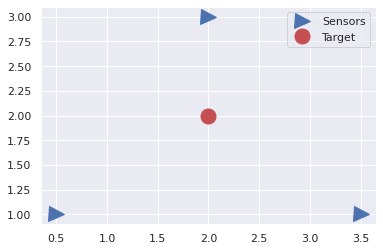

In [8]:
plt.plot(*config['generator']['pos_s'].unbind(dim=1), 'b>', label='Sensors', ms=15)
plt.plot(*config['target'], 'ro', label='Target', ms=15)
plt.legend()

### Defintion of the NNs that define the posterior mean and covariance matrix

We use a common layer and a different layer for mean and diagonal of the covariance matrix.

In [9]:
class Posterior_moments(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()

        # Neural networks for the mean and (logarithm of the) variance
        self.mean = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, z_dim)
        )
        
        # Since variance has to be a positive definite, we assume
        # the network outpus the logarithm of the diagonal of the 
        # covariance matrix variance
        self.logvar = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, z_dim)
        )

    def forward(self, x):  # Pass the input tensor through each of our operations
        mean = self.mean(x)
        logvar = self.logvar(x)
        
        return mean, logvar

In [10]:
Qz_x = Posterior_moments(input_dim=config['num_sensors'] * config['samples_per_sensor'], 
                         z_dim=2,
                         hidden_dim=config['posterior']['hidden_dim'])

### Class to evaluate the loss function (ELBO)

Lets create a new class inherited that takes the likelihood function, prior distribution and posterior approximation and adds two functionalities: one to sample from $q(\mathbf{z}|\mathbf{X})$ and one to evaluate the ELBO

In [11]:
class Model(nn.Module):
    def __init__(self, Px_z, Pz, Qz_x):
        super().__init__()

        self.Qz_x = Qz_x
        self.Px_z = Px_z
        self.Pz = Pz
        
        self.z_dim = self.Px_z.z_dim

    def evaluate_log_prior(self,z):
        return self.Pz.log_prob(z)

    def get_q_params(self, x):
        mean, logvar = self.Qz_x(x)
        return mean, logvar
    
    def sample_from_q(self, x, nsamples=1):
        mean, logvar = self.Qz_x(x)

        # Sampling from q(z|x).
        # We first sample from N(0,I)
        # Then, scale by std and sum the mean

        noise = torch.randn(nsamples, 2)
        sample = mean + torch.exp(0.5 * logvar) * noise
        return sample, mean, logvar

    def ELBO(self, x):
        z_q,  mean_q, logvar_q = self.sample_from_q(x, 20)

        # KL posterior || prior
        KL = -0.5 * self.z_dim + 0.5 * torch.sum(torch.exp(logvar_q) + mean_q ** 2 - logvar_q)

        # Evaluate log-likelihood for the current z sample
        # To do this we use the probabilistic model!

        # Signal mean per sensor
        log_lik = self.Px_z.evaluate(x, z_q).mean(dim=0).sum()

        ELBO_loss = log_lik - KL

        return ELBO_loss, log_lik, KL

In [12]:
# The prior distribution encodes our prior knowledge about the parameters
Pz = MultivariateNormal(torch.zeros(2), torch.eye(2))
model = Model(Px_z, Pz, Qz_x)

### Class to perform ELBO optimization

Create a new class that implements a method `train_step` to perform a SGD step over the variational bound (ELBO)

In [13]:
class Trainer:
    def __init__(self, model, l_rate=1e-5, beta1=0.9, beta2=0.999):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=l_rate, betas=(beta1, beta2))

    def train_step(self, x):
        self.optimizer.zero_grad()
        
        ELBO_loss, log_lik, KL = self.model.ELBO(x)
        nELBO_loss = -ELBO_loss # Multiply by -1 to minimize
        
        nELBO_loss.backward()
        self.optimizer.step()
        
        return ELBO_loss, log_lik, KL
    
    def train(self, x, steps, print_every=4, save_every=10):
        self.model.train()
        for i in range(steps):
            ELBO_loss, log_lik, KL = self.train_step(x)
            if i % print_every == 0:
                ELBO_loss = ELBO_loss.data.cpu().numpy()
                log_lik = log_lik.data.cpu().numpy()
                KL = KL.data.cpu().numpy()
                print('Step = %d, loglik = %.5f, KL = %.5f, ELBO = %.5f' %(i,log_lik,KL, -ELBO_loss))



In [14]:
# x_train = torch.from_numpy(X.reshape([1,-1]))
x_train = X.view(1, -1)
trainer = Trainer(model, l_rate=1e-2, beta1=0.7, beta2=0.999)

We fix the seed for reproducibility

In [15]:
import numpy as np

In [16]:
torch.manual_seed(20)
np.random.seed(20)
trainer.train(x_train, steps=10000, print_every=1000, save_every=10)

Step = 0, loglik = -852.37994, KL = 1.70368, ELBO = 854.08362
Step = 1000, loglik = -37.82026, KL = 8.79189, ELBO = 46.61215
Step = 2000, loglik = -37.89862, KL = 8.84014, ELBO = 46.73876
Step = 3000, loglik = -38.19219, KL = 8.83068, ELBO = 47.02287
Step = 4000, loglik = -37.75082, KL = 8.91622, ELBO = 46.66705
Step = 5000, loglik = -38.23130, KL = 8.71264, ELBO = 46.94393
Step = 6000, loglik = -37.93798, KL = 8.79280, ELBO = 46.73078
Step = 7000, loglik = -37.73262, KL = 8.85836, ELBO = 46.59097
Step = 8000, loglik = -38.15652, KL = 8.87030, ELBO = 47.02682
Step = 9000, loglik = -38.00257, KL = 8.89835, ELBO = 46.90092


### Plot the results

* Get the optimal parameters of the approximated posterior distribution found during the optimization
* Generate `nsamples` from the posterior
* Plot the generated samples, the true position of the target and the position of the sensors

In [17]:
with torch.no_grad():  # Disables gradient computation (locally)
    nsamples = 50
    model.eval()

    q_mean, q_log_var = model.get_q_params(x_train)
    samples = q_mean + torch.exp(0.5 * q_log_var) * torch.randn(nsamples, 2)
    log_prior = model.evaluate_log_prior(samples)
    Plog_pxz_eval = Px_z.evaluate_joint(x_train, samples, log_prior)

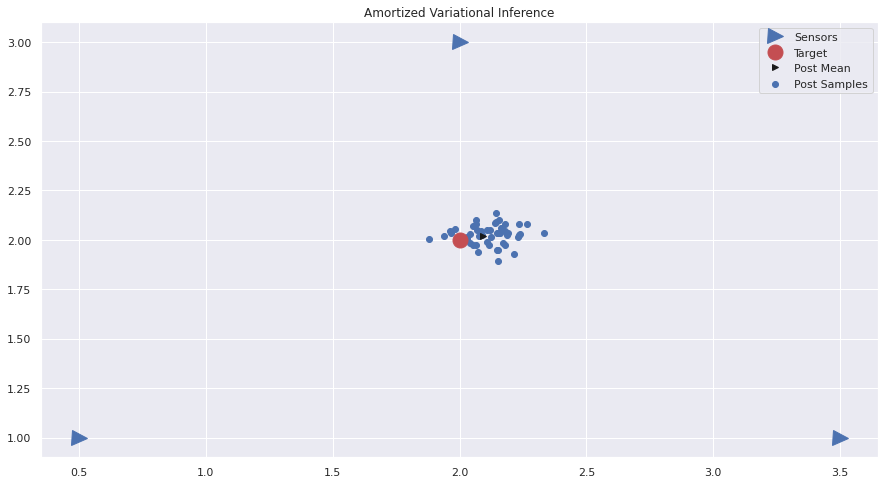

In [18]:

f = plt.figure(figsize=(15,8))

ax = plt.subplot(1, 1, 1)
ax.plot(*config['generator']['pos_s'].unbind(dim=-1), 'b>', label='Sensors', ms=15)
ax.plot(*config['target'], 'ro', label='Target', ms=15)
ax.scatter(samples[:,0], samples[:,1],label='Post Samples')
ax.plot(q_mean[:, 0], q_mean[:, 1], 'k>', label='Post Mean')
ax.set_title('Amortized Variational Inference')
ax.legend()


plt.show()